In [2]:
from gpu_helper import enable_gpu
enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [3]:
from toai.imports import *
from toai.data.utils import split_df
from toai.image import ImageResizer
import tensorflow as tf
from tensorflow import keras
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
%load_ext lab_black
%matplotlib inline
%load_ext tensorboard

In [5]:
DATA_DIR = Path("data/ArTaxOr")
DATA_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

LOGS_DIR = Path("logs")
LOGS_DIR.mkdir(parents=True, exist_ok=True)

## Inspect data

In [6]:
!ls {DATA_DIR}

 ArTaxOr.png   Coleoptera   Hemiptera	  Lepidoptera   readme.txt
 Araneae       Diptera	    Hymenoptera   license.txt  'revision history.txt'


In [7]:
sample = (
    DATA_DIR
    / "Araneae"
    / "annotations"
    / os.listdir(DATA_DIR / "Araneae" / "annotations")[0]
)
with open(sample) as f:
    parsed = json.load(f)
    print(json.dumps(parsed, indent=4))

{
    "asset": {
        "format": "jpg",
        "id": "2ec404df21d8415f5be4c9cf7577bce7",
        "name": "7e26a39d8459.jpg",
        "path": "file:F:/ArTaxOr/Araneae/7e26a39d8459.jpg",
        "size": {
            "width": 1536,
            "height": 2048
        },
        "state": 2,
        "type": 1
    },
    "regions": [
        {
            "id": "lnJs7v5SP",
            "type": "RECTANGLE",
            "tags": [
                "Araneae"
            ],
            "boundingBox": {
                "height": 643.4329501915709,
                "width": 525.7318007662835,
                "left": 602.2375478927203,
                "top": 704.2452107279693
            },
            "points": [
                {
                    "x": 602.2375478927203,
                    "y": 704.2452107279693
                },
                {
                    "x": 1127.9693486590038,
                    "y": 704.2452107279693
                },
                {
                    "x

## Extract data

In [8]:
def extract_bounding_box(regions):
    points = regions[0]["points"]

    return [*points[0].values(), *points[2].values()]

In [9]:
def extract_file_info(asset_file, path):
    asset = asset_file["asset"]
    return [str(path / asset["name"])] + list(asset["size"].values())

In [10]:
def json_files_only(files):
    return [file for file in files if file.endswith(".json")]

In [11]:
def build_dataset(names):
    df = pd.DataFrame()

    for name in names:
        annotations_dir = DATA_DIR / name / "annotations"

        file_infos = []
        bboxs = []
        name_df = pd.DataFrame()
        for annotation in json_files_only(os.listdir(annotations_dir)):
            with open(annotations_dir / annotation) as json_file:
                parsed_json = json.load(json_file)
                regions = parsed_json["regions"]
                if len(regions) == 1:
                    file_infos.append(
                        [annotation, name]
                        + extract_file_info(parsed_json, DATA_DIR / name)
                    )
                    bboxs.append(extract_bounding_box(regions))

        name_df[["annotation", "tag", "file", "width", "height"]] = pd.DataFrame(
            file_infos
        )
        name_df[["x", "y", "x1", "y1"]] = pd.DataFrame(bboxs)

        df = df.append(name_df)

    return df

In [12]:
df = build_dataset(names=["Araneae", "Hemiptera"])
df.shape

(4286, 9)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4286 entries, 0 to 2164
Data columns (total 9 columns):
annotation    4286 non-null object
tag           4286 non-null object
file          4286 non-null object
width         4286 non-null int64
height        4286 non-null int64
x             4286 non-null float64
y             4286 non-null float64
x1            4286 non-null float64
y1            4286 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 334.8+ KB


In [14]:
df.describe()

,width,height,x,y,x1,y1
count,4286.000000,4286.000000,4286.000000,4286.000000,4286.000000,4286.000000
mean,1785.635324,1485.639991,433.211202,306.528973,1353.281706,1183.272460
std,547.763432,444.094890,281.316141,229.197334,432.539401,386.891897
min,500.000000,375.000000,0.000000,0.000000,319.513410,286.874706
25%,1489.000000,1291.250000,224.069127,139.059148,1075.300753,936.006062
50%,2044.500000,1463.000000,402.332142,255.457334,1355.774545,1154.301702
75%,2048.000000,1639.000000,596.038621,429.609195,1594.791724,1376.850575
max,5184.000000,5184.000000,2584.849655,1759.540230,4443.939310,3453.654602


In [15]:
df["x"] = df["x"] / df["width"]
df["x1"] = df["x1"] / df["width"]
df["y"] = df["y"] / df["height"]
df["y1"] = df["y1"] / df["height"]

df["object_width"] = df["x1"] - df["x"]
df["object_height"] = df["y1"] - df["y"]

In [16]:
df.head()

,annotation,tag,file,width,height,x,y,x1,y1,object_width,object_height
0,2ec404df21d8415f5be4c9cf7577bce7-asset.json,Araneae,data/ArTaxOr/Araneae/7e26a39d8459.jpg,1536,2048,0.392082,0.343870,0.734355,0.658046,0.342273,0.314176
1,cb3ee2eb83d63dc0fe14c50c7adc3e4c-asset.json,Araneae,data/ArTaxOr/Araneae/81fc2d800057.jpg,2048,1536,0.416307,0.315134,0.527658,0.624521,0.111351,0.309387
2,f3fe6bc9ee60243271c9b6ce83887c7a-asset.json,Araneae,data/ArTaxOr/Araneae/410d4859f98f.jpg,4160,3120,0.398348,0.289272,0.633261,0.590038,0.234914,0.300766
3,5338978297829b020dd2a70694677cd5-asset.json,Araneae,data/ArTaxOr/Araneae/3548ca9e1537.jpg,1627,2048,0.357302,0.340038,0.652839,0.664751,0.295537,0.324713
4,8c18a24d0d64a2dfec29017b5961604f-asset.json,Araneae,data/ArTaxOr/Araneae/130e77c4c342.jpg,2048,1638,0.371396,0.239464,0.777526,0.968391,0.406130,0.728927


## Preparing the dataset

In [17]:
BATCH_SIZE = 16
SHUFFLE_SIZE = 128
IMG_DIMS = (224, 224, 3)

In [18]:
cat_encoder = LabelEncoder()
cat_encoder.fit(df["tag"])
df["tag"] = cat_encoder.transform(df["tag"])

In [19]:
cat_encoder.classes_

array(['Araneae', 'Hemiptera'], dtype=object)

In [20]:
df.head()

,annotation,tag,file,width,height,x,y,x1,y1,object_width,object_height
0,2ec404df21d8415f5be4c9cf7577bce7-asset.json,0,data/ArTaxOr/Araneae/7e26a39d8459.jpg,1536,2048,0.392082,0.343870,0.734355,0.658046,0.342273,0.314176
1,cb3ee2eb83d63dc0fe14c50c7adc3e4c-asset.json,0,data/ArTaxOr/Araneae/81fc2d800057.jpg,2048,1536,0.416307,0.315134,0.527658,0.624521,0.111351,0.309387
2,f3fe6bc9ee60243271c9b6ce83887c7a-asset.json,0,data/ArTaxOr/Araneae/410d4859f98f.jpg,4160,3120,0.398348,0.289272,0.633261,0.590038,0.234914,0.300766
3,5338978297829b020dd2a70694677cd5-asset.json,0,data/ArTaxOr/Araneae/3548ca9e1537.jpg,1627,2048,0.357302,0.340038,0.652839,0.664751,0.295537,0.324713
4,8c18a24d0d64a2dfec29017b5961604f-asset.json,0,data/ArTaxOr/Araneae/130e77c4c342.jpg,2048,1638,0.371396,0.239464,0.777526,0.968391,0.406130,0.728927


In [21]:
train_df, val_df, test_df = split_df(df, 0.2, "tag")

In [22]:
class ImageParser:
    n_channels: int = 3

    def __call__(self, filename: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)

        return image, label

__Note__ 

Use `num_parallel_calls=tf.data.experimental.AUTOTUNE` for _map()_ functions as it speeds up mapping process quite a lot.  
Without this param it takes:
- 3.51 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

With:
- 1.35 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [23]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_df["file"],
            tuple(
                [
                    train_df["tag"].values,
                    train_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [24]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            val_df["file"],
            tuple(
                [
                    val_df["tag"].values,
                    val_df[["x", "y", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(
        ImageResizer(IMG_DIMS, "stretch"),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [25]:
def make_rectangle(x0, y0, width, height, img_dims, color, linewidth=2):
    return Rectangle(
        (x0 * img_dims[1], y0 * img_dims[0]),
        width * img_dims[1],
        height * img_dims[0],
        linewidth=linewidth,
        edgecolor=color,
        facecolor="none",
    )

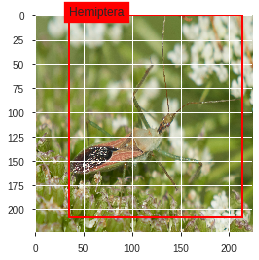

In [26]:
for x, y in train_set.take(1):
    categories, bounding_boxes = y
    category = categories[0].numpy()
    bounding_box = bounding_boxes[0].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(x[0].numpy())
    plt.text(
        bounding_box[0] * IMG_DIMS[0],
        bounding_box[1] * IMG_DIMS[1],
        cat_encoder.inverse_transform([category])[0],
        backgroundcolor="red",
        fontsize=12,
    )
    y_rect = make_rectangle(*bounding_box, IMG_DIMS, "r")
    ax.add_patch(y_rect)
    plt.show()

## Creating the model

In [27]:
class GlobalConcatPooling2D(keras.layers.Layer):
    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        return keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(layer),
                keras.layers.GlobalMaxPool2D()(layer),
            ]
        )

In [28]:
n_categories = len(cat_encoder.classes_)

In [29]:
def make_model():
    base = keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
    x = keras.layers.GlobalMaxPool2D()(base.output)
    x = keras.layers.Dropout(0.3)(x)
    category = keras.layers.Dense(n_categories, activation=keras.activations.softmax)(x)
    bounding_box = keras.layers.Dense(4, activation=keras.activations.sigmoid)(x)
    model = keras.Model(inputs=base.input, outputs=[category, bounding_box])
    model.compile(
        loss=[
            keras.losses.SparseCategoricalCrossentropy(),
            keras.losses.BinaryCrossentropy(),
        ],
        loss_weights=[0.4, 0.9],
        optimizer=keras.optimizers.Adam(2e-4),
    )
    return model

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODEL_DIR / "model.h5"), save_best_only=True, save_weights_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir=str(LOGS_DIR), histogram_freq=1),
]

In [33]:
model = make_model()

In [34]:
model.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH_SIZE),
    epochs=20,
    callbacks=callbacks,
)

Train for 215 steps, validate for 27 steps
Epoch 1/20
215/215 [==============================] - 53s 247ms/step - loss: 0.6578 - dense_2_loss: 0.3021 - dense_3_loss: 0.5966 - val_loss: 0.5992 - val_dense_2_loss: 0.2195 - val_dense_3_loss: 0.5682
Epoch 2/20
215/215 [==============================] - 51s 238ms/step - loss: 0.5512 - dense_2_loss: 0.1035 - dense_3_loss: 0.5665 - val_loss: 0.5732 - val_dense_2_loss: 0.1714 - val_dense_3_loss: 0.5607
Epoch 3/20
215/215 [==============================] - 52s 240ms/step - loss: 0.5245 - dense_2_loss: 0.0527 - dense_3_loss: 0.5593 - val_loss: 0.6046 - val_dense_2_loss: 0.2505 - val_dense_3_loss: 0.5604
Epoch 4/20
215/215 [==============================] - 52s 242ms/step - loss: 0.5127 - dense_2_loss: 0.0312 - dense_3_loss: 0.5558 - val_loss: 0.6278 - val_dense_2_loss: 0.3108 - val_dense_3_loss: 0.5594
Epoch 5/20
215/215 [==============================] - 49s 227ms/step - loss: 0.5000 - dense_2_loss: 0.0123 - dense_3_loss: 0.5501 - val_loss: 0.5

In [45]:
def predict(model, dataset, n_image=0):
    for x, y in dataset.take(1):
        fig, ax = plt.subplots(1)
        ax.imshow(x[n_image].numpy())

        p_categories, p_bounding_boxes = model.predict(x)
        p_category = p_categories[n_image].argmax()
        p_bounding_box = p_bounding_boxes[n_image]
        plt.text(
            (p_bounding_box[0] + p_bounding_box[2]) * IMG_DIMS[0] - 25,
            p_bounding_box[1] * IMG_DIMS[1],
            cat_encoder.inverse_transform([p_category])[0],
            color="white",
            backgroundcolor="blue",
            fontsize=16,
        )
        p_rect = make_rectangle(*p_bounding_box, IMG_DIMS, "b", 3)
        ax.add_patch(p_rect)

        y_categories, y_bounding_boxes = y
        y_category = y_categories[n_image].numpy()
        y_bounding_box = y_bounding_boxes[n_image].numpy()
        plt.text(
            y_bounding_box[0] * IMG_DIMS[0] + 5,
            y_bounding_box[1] * IMG_DIMS[1],
            cat_encoder.inverse_transform([category])[0],
            backgroundcolor="red",
            fontsize=16,
        )
        y_rect = make_rectangle(*y_bounding_box, IMG_DIMS, "r")
        ax.add_patch(y_rect)

        plt.show()

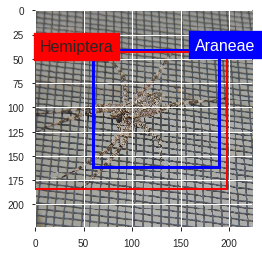

In [50]:
predict(model, validation_set, 3)